# Findings

1. Pretrained ResNet50 classifier fine-tuned on 600 images (200 per tumor type) at image size 64x64 for 10 epochs achieved 86% accuracy when using softmax.
2. KNN classifier with 5 neighbors using the features extracted from the penultimate layer of the ResNet50 model achieved 96% accuracy.
3. 2048 features extracted from the ResNet50 model take up 0.06% of the original image size on average (original dataset: 700MB, feature dataset: 420KB) and allow for comparison between MRI scans taken from different views (sagittal, coronal, axial) due to being abstract representations of the images.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

import random

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DATA_PATH = './data/brain_tumor/'
MENINGIOMA_PATH = DATA_PATH + 'meningioma/'
GLIOMA_PATH = DATA_PATH + 'glioma/'
PITUITARY_PATH = DATA_PATH + 'pituitary/'

In [3]:
# COUNTS
meningioma_count = len(os.listdir(MENINGIOMA_PATH))
glioma_count = len(os.listdir(GLIOMA_PATH))
pituitary_count = len(os.listdir(PITUITARY_PATH))

In [4]:
meningioma_count, glioma_count, pituitary_count

(708, 1426, 930)

In [11]:
# Dataloader
train_data = []

n = 800
s = 128

for i in os.listdir(MENINGIOMA_PATH)[:n]:
    train_data.append([MENINGIOMA_PATH + i, 0])
for i in os.listdir(GLIOMA_PATH)[:n]:
    train_data.append([GLIOMA_PATH + i, 1])
for i in os.listdir(PITUITARY_PATH)[:n]:
    train_data.append([PITUITARY_PATH + i, 2])


train_data = pd.DataFrame(train_data, columns=['image', 'label'])
train_data = train_data.sample(frac=1).reset_index(drop=True)

train_data, test_data = train_test_split(train_data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

class BrainTumorDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = plt.imread(img_name)
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms for the images
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((s, s)),
    # Grayscale
    transforms.Grayscale(num_output_channels=3),
    # Random augmentations
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((s, s)),
    # Grayscale
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [12]:
# Basic CNN ResNet50 for classification
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Linear(2048, 3)

model = model.to(device)

In [13]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        model.train()
        train_loss = 0.0

        # Add tqdm progress bar for the training loop
        train_bar = tqdm(train_loader, desc="Training")
        for i, data in enumerate(train_bar):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            train_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)
        print(f'Train Loss: {train_loss:.4f}')

        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        # Add tqdm progress bar for the validation loop
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader, desc="Validation")):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f'Val Loss: {val_loss:.4f}')

            val_losses.append(val_loss)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses

In [14]:
# Train
batch_size = 128

train_dataset = BrainTumorDataset(train_data, train_transform)
val_dataset = BrainTumorDataset(val_data, val_transform)
test_dataset = BrainTumorDataset(test_data, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [9]:
# model.load_state_dict(torch.load('best_model.pth'))

In [15]:
train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion, epochs=10)


Epoch 1/10


Training: 100%|██████████| 12/12 [00:30<00:00,  2.55s/it, loss=0.399]


Train Loss: 0.7898


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Val Loss: 46.9458

Epoch 2/10


Training: 100%|██████████| 12/12 [00:32<00:00,  2.69s/it, loss=0.394]


Train Loss: 0.3902


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Val Loss: 7.3350

Epoch 3/10


Training: 100%|██████████| 12/12 [00:29<00:00,  2.44s/it, loss=0.532]


Train Loss: 0.2908


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Val Loss: 1.2695

Epoch 4/10


Training: 100%|██████████| 12/12 [00:30<00:00,  2.53s/it, loss=0.167]


Train Loss: 0.2516


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Val Loss: 0.3905

Epoch 5/10


Training: 100%|██████████| 12/12 [00:29<00:00,  2.47s/it, loss=0.231]


Train Loss: 0.2008


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Val Loss: 0.4404

Epoch 6/10


Training: 100%|██████████| 12/12 [00:31<00:00,  2.59s/it, loss=0.159]


Train Loss: 0.1743


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Val Loss: 0.5993

Epoch 7/10


Training: 100%|██████████| 12/12 [00:28<00:00,  2.41s/it, loss=0.4]  


Train Loss: 0.1868


Validation: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Val Loss: 0.8481

Epoch 8/10


Training: 100%|██████████| 12/12 [00:29<00:00,  2.43s/it, loss=0.135]


Train Loss: 0.1949


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Val Loss: 0.6108

Epoch 9/10


Training: 100%|██████████| 12/12 [00:29<00:00,  2.47s/it, loss=0.205] 


Train Loss: 0.1521


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


Val Loss: 0.4211

Epoch 10/10


Training: 100%|██████████| 12/12 [00:29<00:00,  2.44s/it, loss=0.157] 


Train Loss: 0.1545


Validation: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]

Val Loss: 0.3286


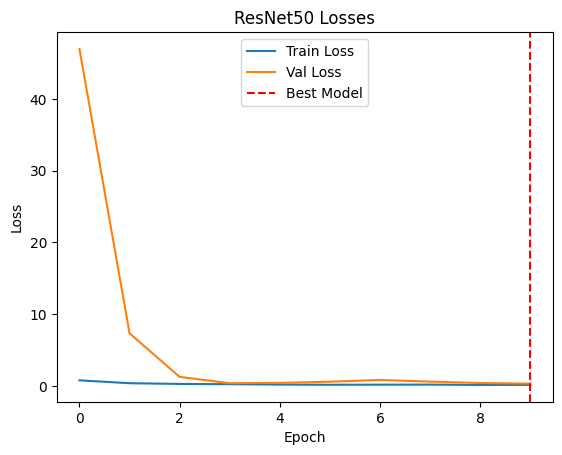

In [16]:
# Plot losses
plt.figure()
# Title: ResNet50 Losses
plt.title('ResNet50 Losses')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
# Plot best model
plt.axvline(np.argmin(val_losses), color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\matth\AppData\Local\Temp\ipykernel_3060\1559688700.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [18]:
# Evaluate
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader, desc="Testing")):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy*100}%')

Testing: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]

Accuracy: 86.58008658008657%


In [19]:
# After training, we set the model to evaluation mode for feature extraction
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Up to the penultimate layer
feature_extractor.eval()

# Function to extract features from the dataloader
def extract_features(dataloader):
    features = []
    labels_list = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            # Pass the inputs through the feature extractor
            output = feature_extractor(inputs)
            output = output.view(output.size(0), -1)  # Flatten the output to (batch_size, 2048)
            features.append(output)
            labels_list.append(labels)
    
    features = torch.cat(features, dim=0).cpu().numpy()  # Convert features to numpy
    labels = torch.cat(labels_list, dim=0).cpu().numpy()  # Convert labels to numpy
    return features, labels

# Extract features from both the training and test set
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Apply KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Set number of neighbors to 5
knn.fit(train_features, train_labels)

# Predict on the test set
test_predictions = knn.predict(test_features)

# Evaluate the accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f'KNN Classification Accuracy: {accuracy * 100:.2f}%')

KNN Classification Accuracy: 92.42%


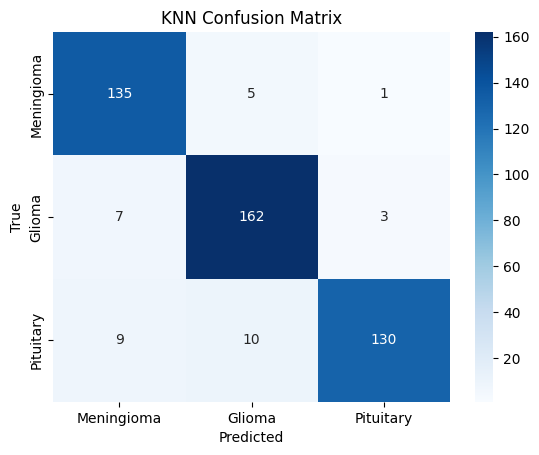

In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, test_predictions)
plt.figure()
# Title: KNN Confusion Matrix
plt.title('KNN Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
# Switch x and y ticks to original class names
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Meningioma', 'Glioma', 'Pituitary'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Meningioma', 'Glioma', 'Pituitary'])
plt.show()

In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

k = 3  # Number of clusters, change based on your dataset (e.g., 3 types of tumors)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(train_features)  # Fit the KMeans model on the features

labels = kmeans.labels_

pca = PCA(n_components=2)  # Reduce the features to 2 dimensions
reduced_features = pca.fit_transform(train_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter)  # Add color bar to show the cluster numbers
plt.title("K-Means Clustering on Feature Vectors (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


<IPython.core.display.Javascript object>

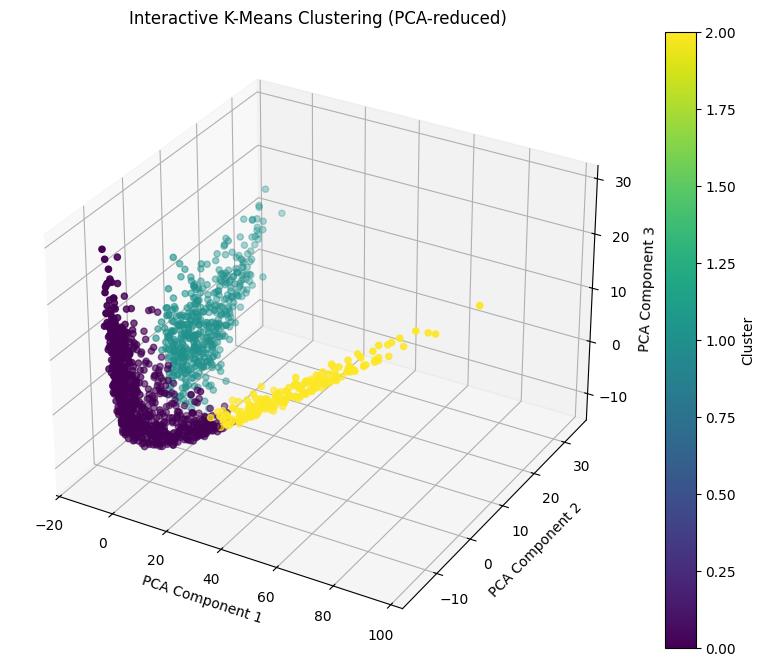

In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(train_features)

labels = kmeans.labels_

pca = PCA(n_components=3)
reduced_features = pca.fit_transform(train_features)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    reduced_features[:, 0], 
    reduced_features[:, 1], 
    reduced_features[:, 2], 
    c=labels, 
    cmap='viridis'
)

# Add labels and color bar
ax.set_title("Interactive K-Means Clustering (PCA-reduced)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
fig.colorbar(scatter, ax=ax, label='Cluster')

plt.show()



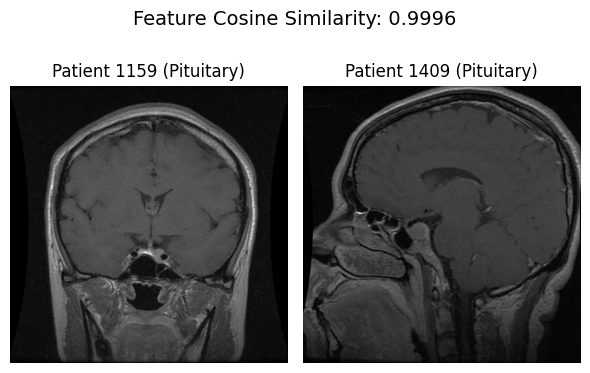

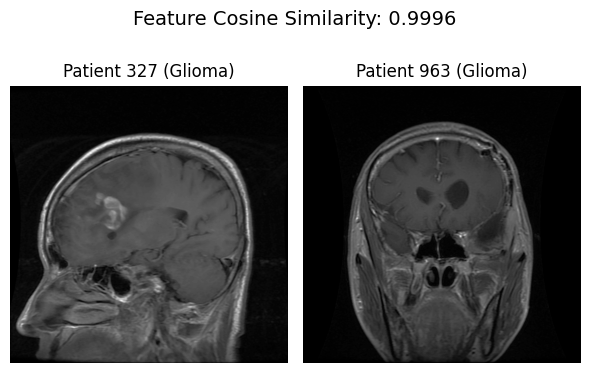

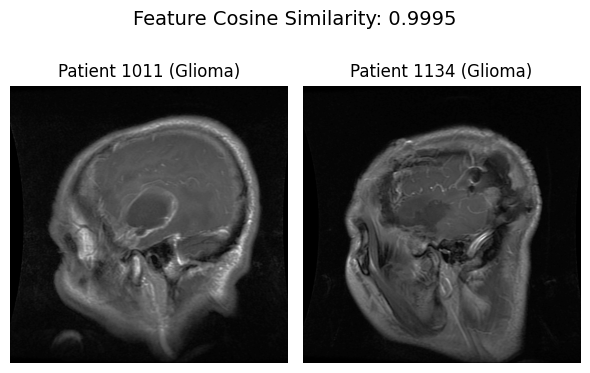

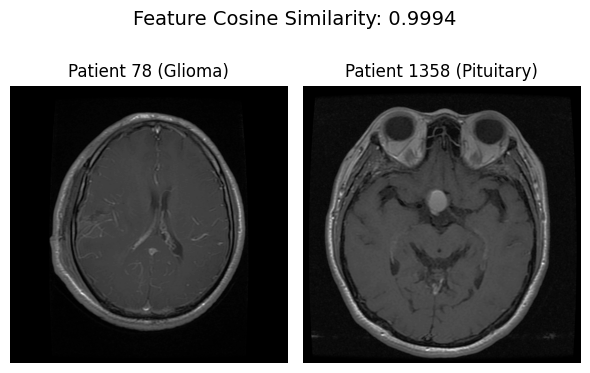

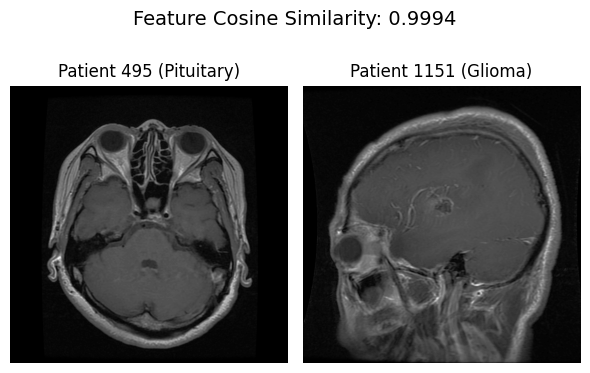

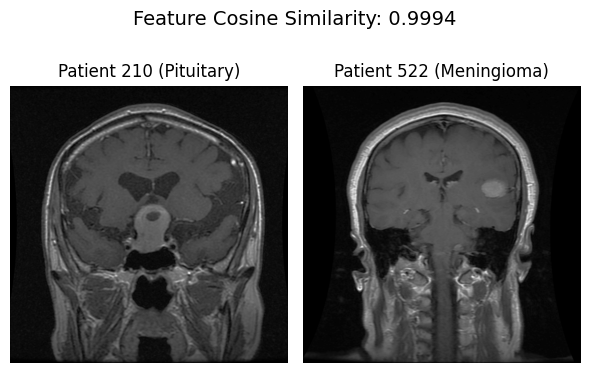

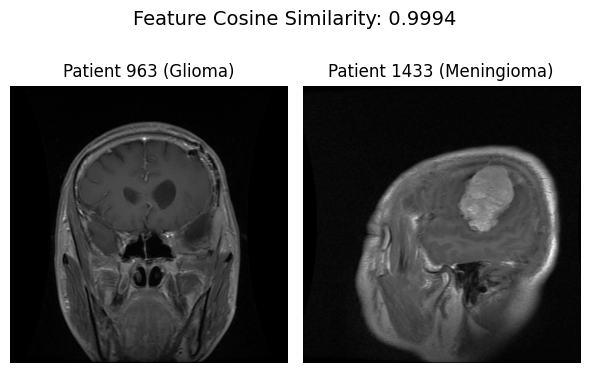

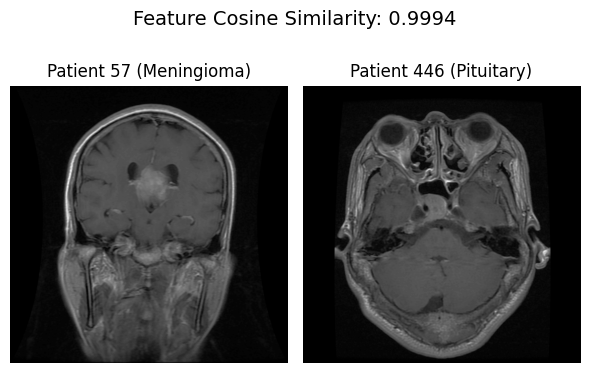

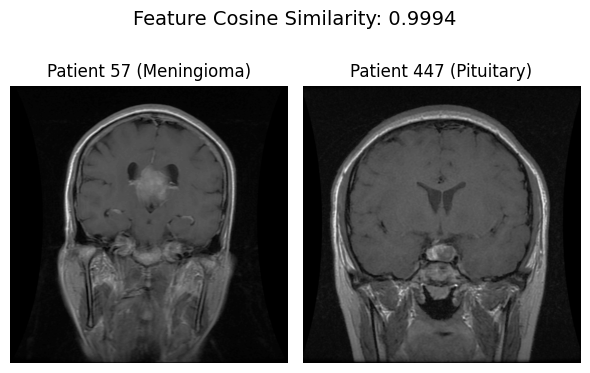

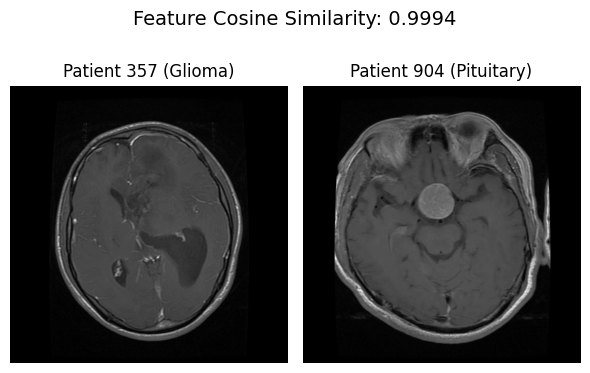

In [29]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming `train_features` is a numpy array of shape (n_samples, 2048)
# `image_paths` is a list of file paths to the MRI images, 
# and `tumor_types` is a list with the tumor type for each patient.
image_paths = train_data['image'].tolist()
tumor_types = train_data['label'].tolist()

# Step 1: Compute cosine similarity between all feature vectors
similarities = cosine_similarity(train_features)  # n_samples x n_samples similarity matrix

# Step 2: Find the most similar pairs
n = similarities.shape[0]
similarity_pairs = []

for i in range(n):
    for j in range(i + 1, n):  # Only consider pairs (i, j) where i < j
        similarity_pairs.append((i, j, similarities[i, j]))

# Sort the pairs by similarity (highest similarity first)
similarity_pairs.sort(key=lambda x: x[2], reverse=True)

# Get top N most similar pairs (for example, top 5)
top_n = 10
top_pairs = similarity_pairs[:top_n]

# Step 3: Plot MRI images in separate figures with tumor type annotations
for idx, (idx1, idx2, sim) in enumerate(top_pairs):
    # Load and display the MRI images for the most similar pair
    img1 = Image.open(image_paths[idx1])
    img2 = Image.open(image_paths[idx2])

    # Convert to grayscale
    img1 = img1.convert('L')
    img2 = img2.convert('L')

    # Tumor types for the current pair
    tumor1 = tumor_types[idx1]
    tumor2 = tumor_types[idx2]

    # Map numeric tumor labels to string labels (0: Meningioma, 1: Glioma, 2: Pituitary)
    tumor1 = ['Meningioma', 'Glioma', 'Pituitary'][tumor1]
    tumor2 = ['Meningioma', 'Glioma', 'Pituitary'][tumor2]

    # Create a new figure for each pair of images
    plt.figure(figsize=(6, 4))

    # Plot the first MRI image
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(f"Patient {idx1} ({tumor1})")
    plt.axis('off')  # Turn off axis

    # Plot the second MRI image
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(f"Patient {idx2} ({tumor2})")
    plt.axis('off')  # Turn off axis

    # Set the title for the entire figure (Similarity score)
    plt.suptitle(f'Feature Cosine Similarity: {sim:.4f}', fontsize=14)

    # Display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title position
    plt.show()


In [31]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch

class TumorClassifierBasedOnSimilarity:
    def __init__(self, train_features, train_labels, image_paths):
        """
        Initialize the classifier with training data.
        
        Parameters:
        train_features (numpy.ndarray): Array of feature vectors (shape: n_samples, 2048)
        train_labels (list): List of labels (0: Meningioma, 1: Glioma, 2: Pituitary)
        image_paths (list): List of image paths
        """
        self.train_features = train_features
        self.train_labels = train_labels
        self.image_paths = image_paths

    def classify(self, new_patient_features):
        """
        Classify a new patient based on cosine similarity.
        
        Parameters:
        new_patient_features (numpy.ndarray): 2048-dimensional feature vector of the new patient
        
        Returns:
        predicted_class (int): Predicted class label (0: Meningioma, 1: Glioma, 2: Pituitary)
        """
        # Step 1: Calculate cosine similarity between the new patient's feature and all training samples
        similarities = cosine_similarity([new_patient_features], self.train_features)[0]
        
        # Step 2: Group training data by class
        class_similarities = {0: [], 1: [], 2: []}  # {0: Meningioma, 1: Glioma, 2: Pituitary}
        
        for idx, label in enumerate(self.train_labels):
            class_similarities[label].append(similarities[idx])
        
        # Step 3: Compute average cosine similarity for each class
        avg_similarities = {label: np.mean(similarities) for label, similarities in class_similarities.items()}
        # Step 4: Assign the class with the highest average similarity
        predicted_class = max(avg_similarities, key=avg_similarities.get)
        
        return predicted_class, avg_similarities

# Example usage:
# Assuming `train_features` is the matrix of feature vectors, `train_labels` is the list of labels,
# and `image_paths` is the list of image file paths.
# You would also need a new patient's features (`new_patient_features`) to classify.

# Initialize the classifier with training data
classifier = TumorClassifierBasedOnSimilarity(train_features, train_labels, image_paths)

# load random patient from dataset
random_idx = np.random.randint(len(train_features))
new_patient_features = train_features[random_idx]


# Classify the new patient
predicted_class, avg_similarities = classifier.classify(new_patient_features)

# Map numeric class to tumor type
tumor_types = ['Meningioma', 'Glioma', 'Pituitary']
print(f"Predicted Tumor Type: {tumor_types[predicted_class]}")
print(f"True Tumor Type: {tumor_types[train_labels[random_idx]]}")
# Similarities table
print("Average Similarities:")
for label, avg_sim in avg_similarities.items():
    print(f"{tumor_types[label]}: {avg_sim:.4f}")



Predicted Tumor Type: Meningioma
True Tumor Type: Meningioma
Average Similarities:
Meningioma: 0.9024
Glioma: 0.4843
Pituitary: 0.4839


In [32]:
# Evaluate the classifier on the test set
test_predictions = []
avg_similarities_list = []

for features in test_features:
    predicted_class, avg_similarities = classifier.classify(features)
    test_predictions.append(predicted_class)
    avg_similarities_list.append(avg_similarities)

# Compute accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")


Classification Accuracy: 88.31%


In [33]:
# Load one set of features from a random patient (pass their image through the model)
random_patient = test_data.sample(1)
random_patient_dataset = BrainTumorDataset(random_patient, val_transform)
random_patient_loader = DataLoader(random_patient_dataset, batch_size=1)

features, labels = extract_features(random_patient_loader)

# Predict the class of the patient using KNN
prediction = knn.predict(features)
print(f'Patient Class: {prediction[0]}')

Patient Class: 1


In [34]:
# OS size of the features in KB vs original image
original_size = os.path.getsize(random_patient.iloc[0, 0]) / 1024
features_size = sys.getsizeof(features) / 1024
print(f'Original Image Size: {original_size:.2f} KB')
print(f'Features Size: {features_size:.2f} KB')
# Percentage of original
print(f'Feature Size as Percentage of Original Image: {features_size / original_size * 100:.2f}%')


Original Image Size: 262.87 KB
Features Size: 0.12 KB
Feature Size as Percentage of Original Image: 0.05%


In [ ]:
# Average size saving for all patients
total_original_size = 0
total_features_size = 0

for i in range(len(test_data)):
    patient = test_data.iloc[i:i+1]
    patient_dataset = BrainTumorDataset(patient, val_transform)
    patient_loader = DataLoader(patient_dataset, batch_size=1)

    features, labels = extract_features(patient_loader)

    original_size = os.path.getsize(patient.iloc[0, 0]) / 1024
    features_size = sys.getsizeof(features) / 1024

    total_original_size += original_size
    total_features_size += features_size

average_original_size = total_original_size / len(test_data)
average_features_size = total_features_size / len(test_data)

print(f'Average Original Image Size: {average_original_size:.2f} KB')
print(f'Average Features Size: {average_features_size:.2f} KB')
print(f'Average Feature Size as Percentage of Original Image: {average_features_size / average_original_size * 100:.2f}%')

Average Original Image Size: 235.47 KB
Average Features Size: 0.12 KB
Average Feature Size as Percentage of Original Image: 0.05%


In [18]:
total_original_size

27252.732421875

In [26]:
# find most common features of the 2048 for each classes, check gradients wrt to them
meningioma_features = train_features[train_labels == 0]
glioma_features = train_features[train_labels == 1]
pituitary_features = train_features[train_labels == 2]

In [35]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer=None):
        self.model = model
        self.feature_maps = None
        self.gradients = None
        self.hooks = []
        
        self.hooks.append(target_layer.register_forward_hook(self._save_feature_maps))
        self.hooks.append(target_layer.register_forward_hook(
            lambda m, i, o: setattr(m, 'feature_maps', o)
        ))
        self.hooks.append(target_layer.register_forward_hook(
            lambda m, i, o: o.requires_grad_(True)
        ))
    
    def _save_feature_maps(self, module, input, output):
        self.feature_maps = output
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
    
    def generate_cam(self, image, target_class):
        self.model.eval()
        output = self.model(image)
        
        if self.feature_maps is None:
            raise ValueError("No feature maps detected")
            
        self.model.zero_grad()
        score = output[0, target_class]
        gradients = torch.autograd.grad(score, self.feature_maps, create_graph=True)[0]

        activations = F.relu(self.feature_maps)  # Only consider positive activations
        weighted_grads = torch.mean(gradients * activations, dim=(2, 3))

        # # Pool gradients
        # pooled_gradients = torch.mean(gradients, dim=(2, 3))
        
        # Weight channels
        for i in range(self.feature_maps.shape[1]):
            # self.feature_maps[:, i, :, :] *= pooled_gradients[0, i]
            self.feature_maps[:, i, :, :] *= weighted_grads[0, i]
            
        # Average channels
        cam = torch.mean(self.feature_maps, dim=1).squeeze()
        cam = F.relu(cam)
        
        cam = cam.detach().cpu().numpy()
        # cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-7)
        cam = np.clip(cam * 5, 0, 1)  # Multiply by 5 to amplify differences, clip to [0,1]
        cam = cv2.resize(cam, (image.shape[3], image.shape[2]))
        
        self.remove_hooks()
        return cam

def visualize_cam(model, image, class_idx):
    # Average of all layers and convs
    grad_cam_1 = GradCAM(model, model.layer1)
    grad_cam_2 = GradCAM(model, model.layer2)
    grad_cam_3 = GradCAM(model, model.layer3)
    grad_cam_4 = GradCAM(model, model.layer4)

    heatmap_1 = grad_cam_1.generate_cam(image, class_idx)
    heatmap_2 = grad_cam_2.generate_cam(image, class_idx)
    heatmap_3 = grad_cam_3.generate_cam(image, class_idx)
    heatmap_4 = grad_cam_4.generate_cam(image, class_idx)

    heatmap = heatmap_1 + heatmap_2 + heatmap_3 + heatmap_4
    
    return heatmap

Predicted: Pituitary
True Label: Pituitary
Meningioma: 0.0451
Glioma: 0.0122
Pituitary: 0.9427


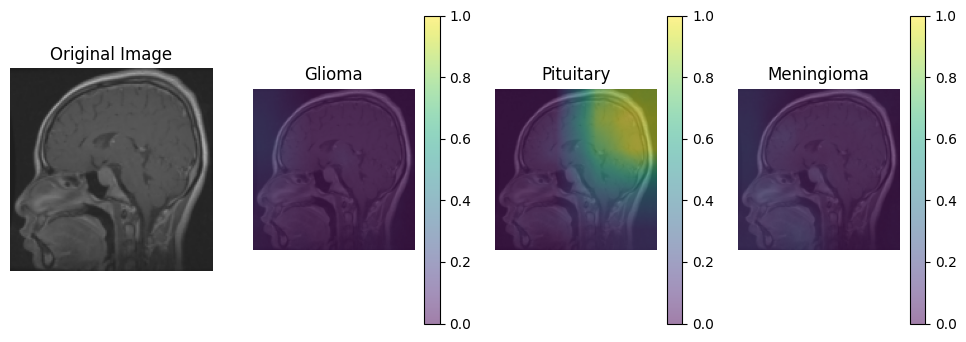

In [64]:
# Load random image
random_patient = test_data.sample(1)
random_patient_dataset = BrainTumorDataset(random_patient, val_transform)
random_patient_loader = DataLoader(random_patient_dataset, batch_size=1)

image, label = next(iter(random_patient_loader))
image = image.to(device)

# preprocess (Resize to 224)

label = label.item()

labels = [0, 1, 2]

label_names = ['Meningioma', 'Glioma', 'Pituitary']

# Output the model's predicted class
output = model(image)
_, predicted = torch.max(output, 1)
print(f'Predicted: {label_names[predicted.item()]}')
print(f'True Label: {label_names[label]}')

# Probabilities for each class
probabilities = F.softmax(output, dim=1).squeeze().cpu().detach().numpy()
for i, prob in enumerate(probabilities):
    print(f'{label_names[i]}: {prob:.4f}')

meningioma_heatmap = visualize_cam(model, image, 0)
glioma_heatmap = visualize_cam(model, image, 1)
pituitary_heatmap = visualize_cam(model, image, 2)

# Scale all heatmaps so differences in activations are visible
max_val = max(meningioma_heatmap.max(), glioma_heatmap.max(), pituitary_heatmap.max())
meningioma_heatmap /= max_val
glioma_heatmap /= max_val
pituitary_heatmap /= max_val

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(image.squeeze().cpu().permute(1, 2, 0).numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image.squeeze().cpu().permute(1, 2, 0).numpy(), cmap='gray')
plt.imshow(glioma_heatmap, cmap='viridis', vmin=0, vmax=1, alpha=0.5)
plt.title('Glioma')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(image.squeeze().cpu().permute(1, 2, 0).numpy(), cmap='gray')
plt.imshow(pituitary_heatmap, cmap='viridis', vmin=0, vmax=1, alpha=0.5)
plt.title('Pituitary')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(image.squeeze().cpu().permute(1, 2, 0).numpy(), cmap='gray')
plt.imshow(meningioma_heatmap, cmap='viridis', vmin=0, vmax=1, alpha=0.5)
plt.title('Meningioma')
plt.axis('off')
plt.colorbar()

plt.show()

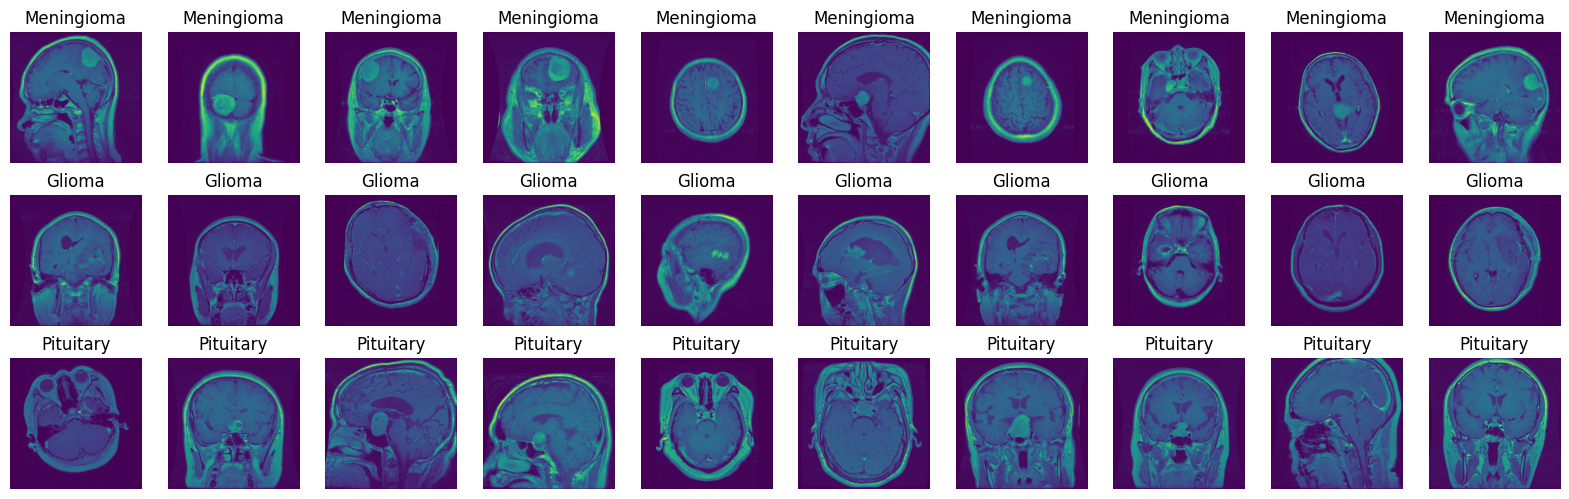

In [44]:
# Plot 10 example images of each class, just the original images in a row
meningioma = test_data[test_data['label'] == 0].sample(10)
glioma = test_data[test_data['label'] == 1].sample(10)
pituitary = test_data[test_data['label'] == 2].sample(10)

plt.figure(figsize=(20, 6))
for i, (idx, patient) in enumerate(meningioma.iterrows()):
    plt.subplot(3, 10, i+1)
    img = plt.imread(patient['image'])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Meningioma')

for i, (idx, patient) in enumerate(glioma.iterrows()):
    plt.subplot(3, 10, i+11)
    img = plt.imread(patient['image'])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Glioma')

for i, (idx, patient) in enumerate(pituitary.iterrows()):
    plt.subplot(3, 10, i+21)
    img = plt.imread(patient['image'])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Pituitary')